In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import librun
from libutil import out_dir
from dotenv import load_dotenv; load_dotenv()
from importlib import reload; import libplot; 
from sklearn import metrics
from tabulate import tabulate
import ipywidgets as widgets
from libplot import align_yaxis
import random
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore")

In [2]:
from libdatasets import *; from libadversarial import uncertainty_stop
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("rcv1-58509", wrap(rcv1, 58509)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        ("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
        
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("res500", lambda learner, matrix, state: state.X_unlabelled.shape[0] < 510),
        "pool_subsample": 1000
    }
}
datasets = [d[0] for d in matrix['datasets']]
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=29)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-c037c54d-ad90-43d4-8c5f-8cd0206cdcf0.json']
Current commit: d73b367



Experiment:   0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
def read_stopping(name):
    file = f"{out_dir()}/stopping2/{name}__none__uncertainty__svm-linear__dataset_size=1000__labelled_size=10__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=r__pool_subsample=1000.pickle"
    with open(file, "rb") as f:
        return dill.load(f)

In [4]:
# this is 10 runs on svm-linear, initial set size 10, no data modification
# None indicates a condition failed to stop
results = {}
for name in datasets:
    results[name] = read_stopping(name)

In [5]:
criteria = set.union(*[set(list(result.keys())) for result in results.values()])
print(f"Stopping Criteria ({len(criteria)}): {criteria}")

Stopping Criteria (25): {'Uncertainty Convergence', 'FirstDiffMinOverallUncertainty', 'Classification Change', 'SecondDiffZeroOverallUncertainty', 'FirstDiffZeroOverallUncertainty', 'FirstDiffZeroOverallUncertainty-weak', 'FirstDiffZeroStabilizingPredictions-alpha1-weak', 'Overall Uncertainty', 'FirstDiffZeroPerformanceConvergence', 'SecondDiffZeroPerformanceConvergence-weak', 'EVM', 'SC_entropy_mcs', 'SSNCut', 'Max Confidence', 'Performance Convergence', 'FirstDiffMinOverallUncertainty-weak', 'SecondDiffZeroPerformanceConvergence', 'SC_oracle_acc', 'Contradictory Information', 'FirstDiffZeroStabilizingPredictions-alpha1', 'FirstDiffZeroPerformanceConvergence-weak', 'Stabilizing Predictions', 'GOAL', 'VM', 'SecondDiffZeroOverallUncertainty-weak'}


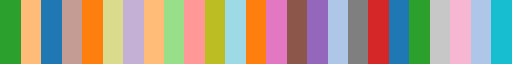

In [10]:
# Seaborn colors
# try husl, hls, gnist_ncar
colors = sns.color_palette('tab20', len(criteria)).as_hex()
random.seed(10); random.shuffle(colors)
criteria_map = {name: color for name, color in zip(criteria, colors)}
cmap = ListedColormap(colors, name='Z'); cmap

In [36]:
results_filter = {dataset: {name: r for name, r in conds.items()} for dataset, conds in results.items()}
to_plot_min = {'Overall Uncertainty', 'Performance Convergence', 'Max Confidence', 'VM', 'SC_entropy_mcs', 'SC_oracle_acc', 'EVM', 'SSNCut', 'Stabilizing Predictions', 'Uncertainty Convergence', 'Classification Change', 'Contradictory Information'}
results_filter_min = {dataset: {name: r for name, r in conds.items() if name in to_plot_min} for dataset, conds in results.items()}

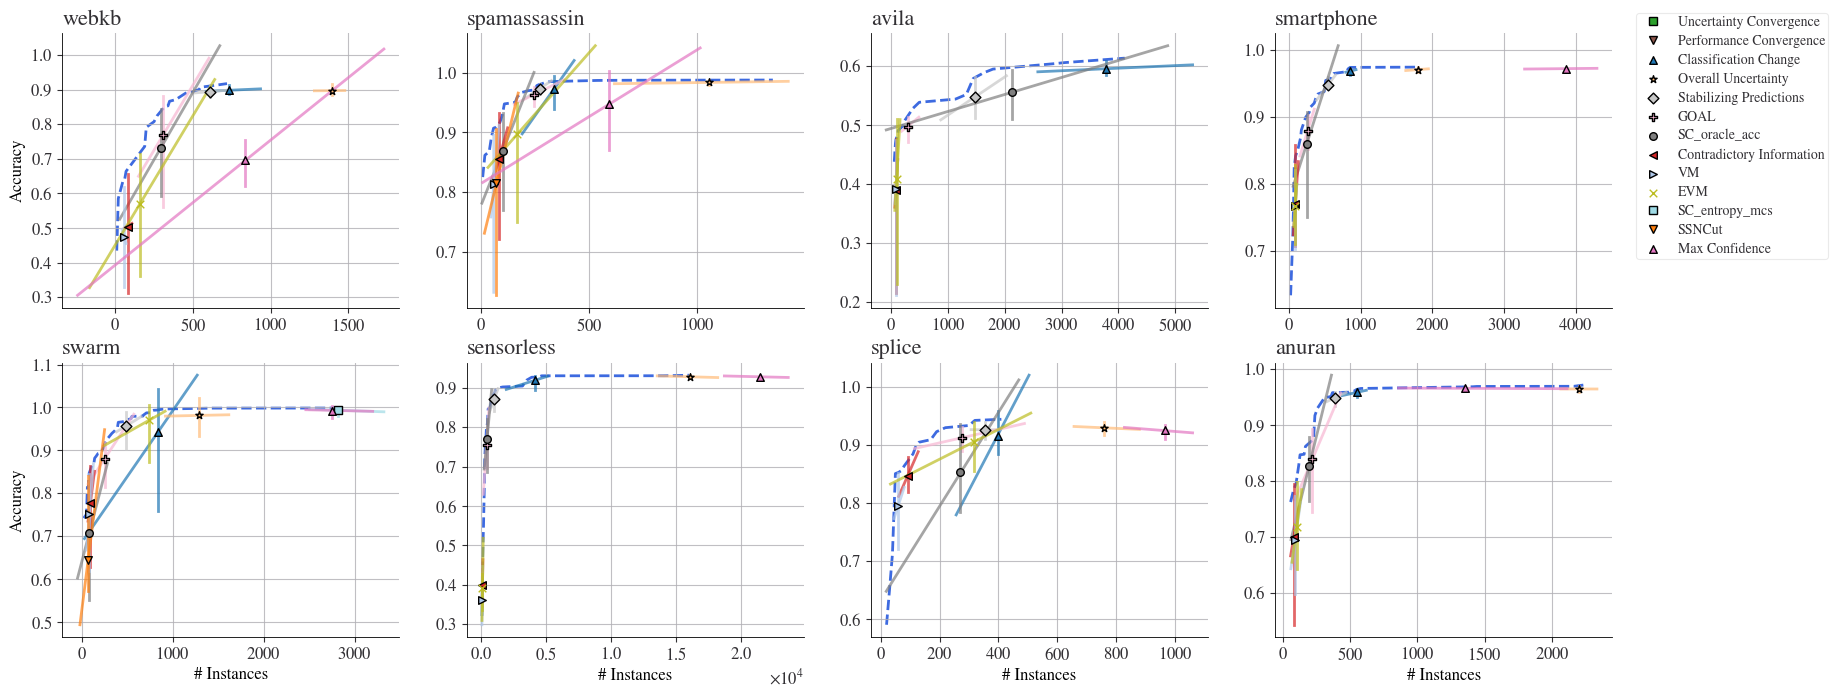

In [13]:
reload(libplot); from libplot import plot_paraeto_hull
with plt.style.context('plt_style.txt'):
    plot_paraeto_hull(results_filter_min, rows=2, cols=4, figsize=(20,8), dpi=100, hull=False, error='pca', colors=criteria_map)

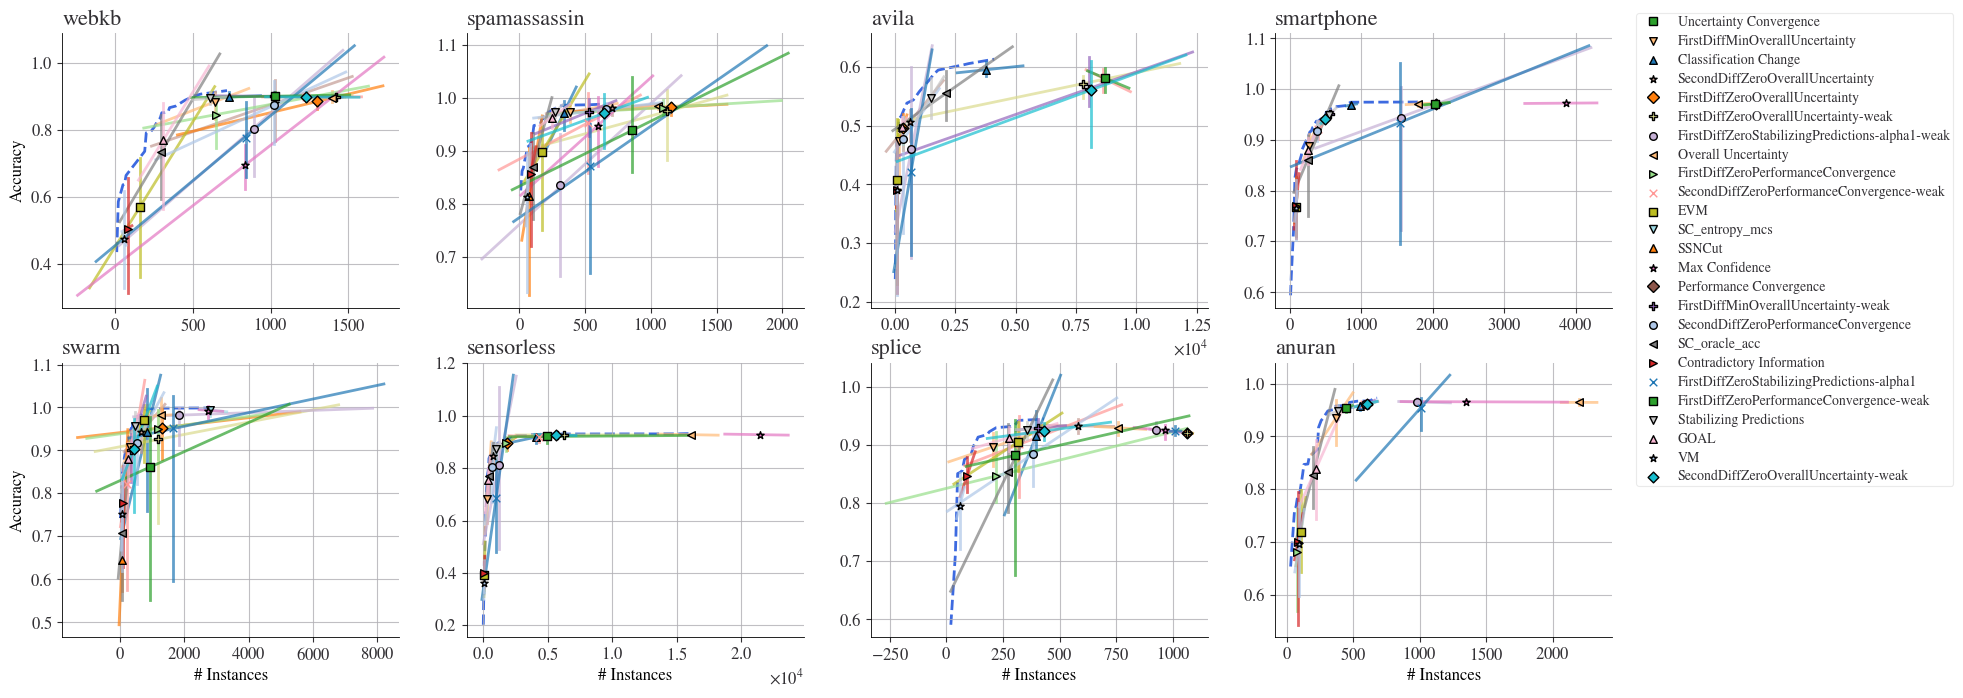

In [15]:
reload(libplot); from libplot import plot_paraeto_hull
with plt.style.context('plt_style.txt'):
    plot_paraeto_hull(results_filter, rows=2, cols=4, figsize=(20,8), dpi=100, hull=False, error='pca', colors=criteria_map)

In [16]:
glob_runs = None
@widgets.interact(dataset=list(results_filter.keys()), criteria=list(list(results_filter.values())[0].keys()))
def explore(dataset: str, criteria: str):
    global glob_runs
    """
    Look at why a particular condition evaluated on a particular dataset gave certain results.
    """

    runs = results_filter[dataset][criteria]
    run_plots = [plots[1] for plots in results_plots if plots[0].dataset_name == dataset][0]
    #print(len(run_plots))
    #assert False
    x = run_plots[0].x
    accuracy_mean = np.mean([run_plot.accuracy_score for run_plot in run_plots], axis=0)
    accuracy_stderr = np.std([run_plot.accuracy_score for run_plot in run_plots], axis=0)
    f1_mean = np.mean([run_plot.f1_score for run_plot in run_plots], axis=0)
    f1_stderr = np.std([run_plot.f1_score for run_plot in run_plots], axis=0)
    roc_auc_mean = np.mean([run_plot.roc_auc_score for run_plot in run_plots], axis=0)
    roc_auc_stderr = np.std([run_plot.roc_auc_score for run_plot in run_plots], axis=0)
    lines = [(accuracy_mean, accuracy_stderr), (f1_mean, f1_stderr), (roc_auc_mean, roc_auc_stderr)]
    
    # Plot accuracy, metric, threshold stuff, possibly even some information about the criteria? Doc comment, paper link, etc.
    fig, axes = plt.subplots(1, 4, figsize=(18,4))
    
    for i, ax in enumerate(axes[:3]):
        line = ax.plot(x, lines[i][0])
        ax.fill_between(
            x,
            lines[i][0]-lines[i][1],
            lines[i][0]+lines[i][1],
            color=line[0].get_color(),
            alpha=0.2
        )
        ax.scatter([run[0] for run in runs], [run[i+1] for run in runs])
        ax.set_xlabel("Instances")
        ax.set_ylabel(["Accuracy", "F1", "ROC AUC"][i])
        
    stopped = np.count_nonzero([run[0] is not None for run in runs])
        
    #print(f"Metric example values: {runs[0][4]}")
    glob_runs = runs
    if runs[0][4] is not None:
        if isinstance(runs[0][4], tuple):
            # Multiple values returned by metric, we take the first and assume it's the right one to plot
            metric_mean = np.mean([run[4][0] for run in runs], axis=0)
            metric_stderr = np.std([run[4][0] for run in runs], axis=0)
            metric_shape = np.array(runs[0][4][0]).shape
        else:
            metric_mean = np.mean([run[4] for run in runs], axis=0)
            metric_stderr = np.std([run[4] for run in runs], axis=0)
            metric_shape = np.array(runs[0][4]).shape
    
        mean_line = axes[3].plot(np.arange(0, metric_shape[0]*10, 10), metric_mean)
        axes[3].fill_between(
            np.arange(0, metric_shape[0]*10, 10), 
            metric_mean-metric_stderr, 
            metric_mean+metric_stderr, 
            color=mean_line[0].get_color(), 
            alpha=0.2
        )
        axes[3].set_xlabel('Instances')
        axes[3].set_ylabel('Metric')
        
        if isinstance(runs[0][4], tuple) and criteria != "GOAL":
            axes4 = axes[3].twinx()
            for extra in range(1, len(runs[0][4])):
                #print(f"Plotting extra metric {extra}")
                extra_mean = np.mean([run[4][extra] for run in runs], axis=0)
                extra_stderr = np.std([run[4][extra] for run in runs], axis=0)
                extra_shape = np.array(runs[0][4][extra]).shape
                extra_line = axes4.plot(np.arange(0, extra_shape[0]*10, 10), extra_mean)
                #print(runs[0][4][extra])
                axes4.fill_between(np.arange(0, metric_shape[0]*10, 10), extra_mean-extra_stderr,extra_mean+extra_stderr, color=extra_line[0].get_color(), alpha=0.2)
            align_yaxis(axes[3], axes4)
        
        if axes[3].get_ylim()[0] < 0 and 0 < axes[3].get_ylim()[1]:
            axes[3].axhline(0, color='grey', ls='--', alpha=0.8)
    
    fig.suptitle(f"{criteria} evaluated on {dataset}")
    
    fig.text(-0.1, -0.2, f"Criteria stopped on {stopped}/{len(runs)} runs", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    
    fig.tight_layout()

interactive(children=(Dropdown(description='dataset', options=('webkb', 'spamassassin', 'avila', 'smartphone',…

In [18]:
from libstop import rank_stop_conds

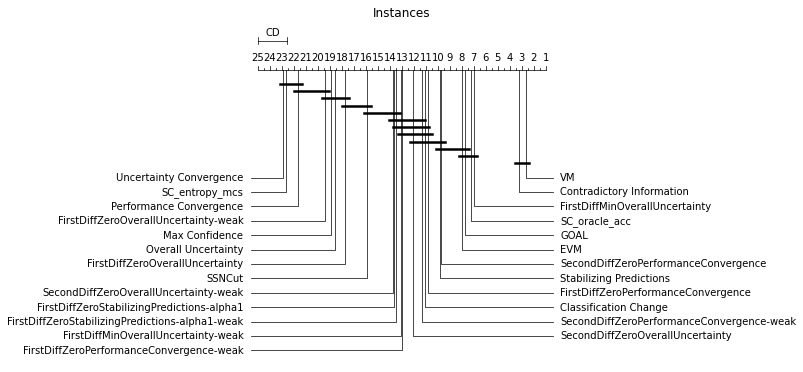

In [19]:
rank_stop_conds(results_filter, "instances");

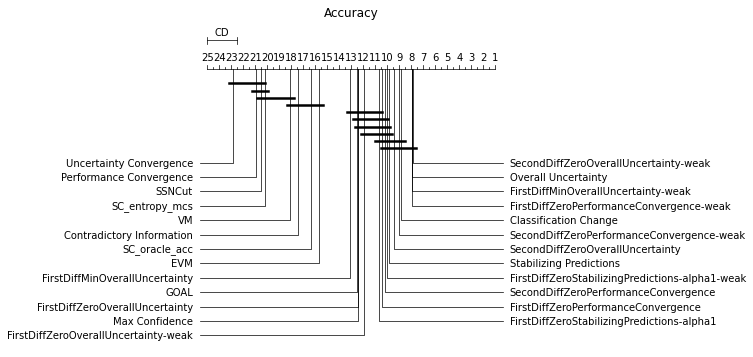

In [20]:
rank_stop_conds(results_filter, "accuracy_score");

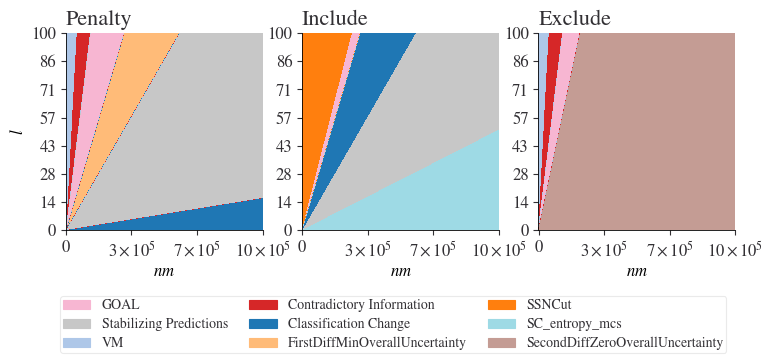

In [23]:
import libregionplot; reload(libregionplot); from libregionplot import regions, costs
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(1, 3, figsize=(7.2*1.2,4.45), dpi=100)
    patches = []
    for i, (ax, mode) in enumerate(zip(axes, ['penalty', 'include', 'exclude'])):
        regions(results_filter, colors=criteria_map, failed_to_stop=mode, title=mode.title(), ax=ax, patches=patches, left=i==0)
    plt.legend(handles=patches, bbox_to_anchor=(0.99, -0.3), ncol=3)

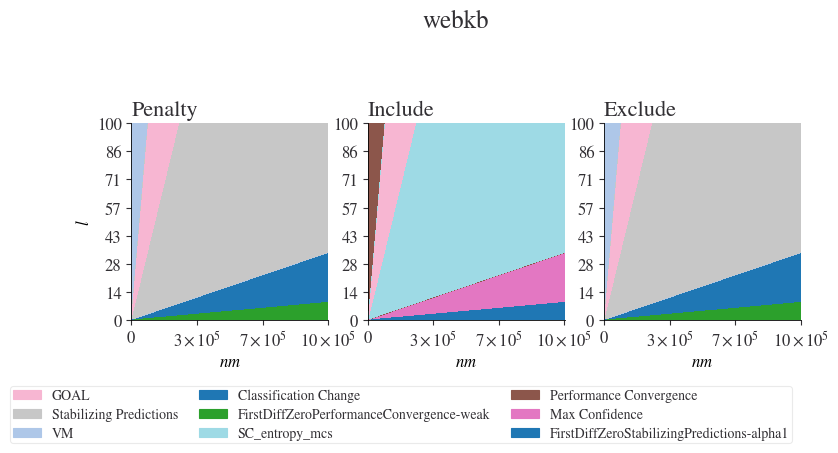

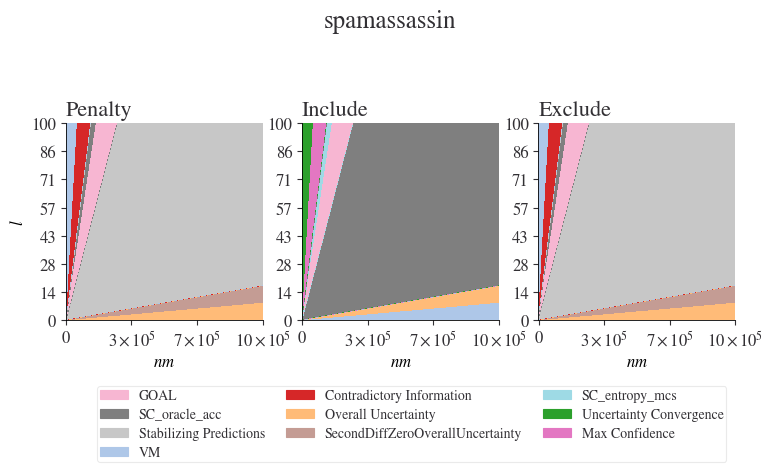

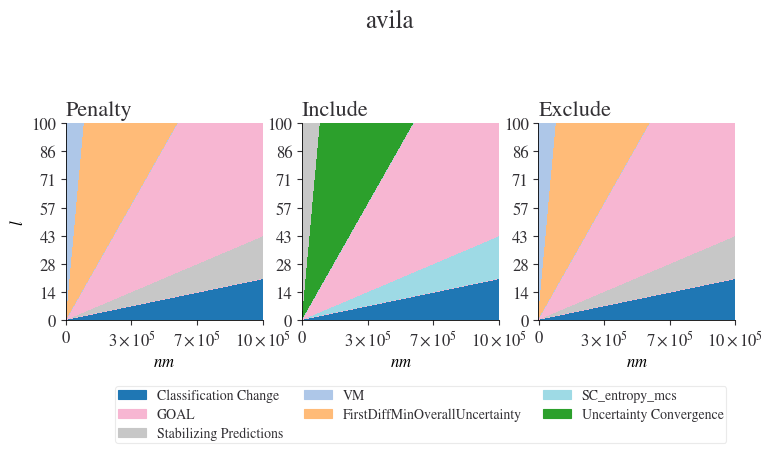

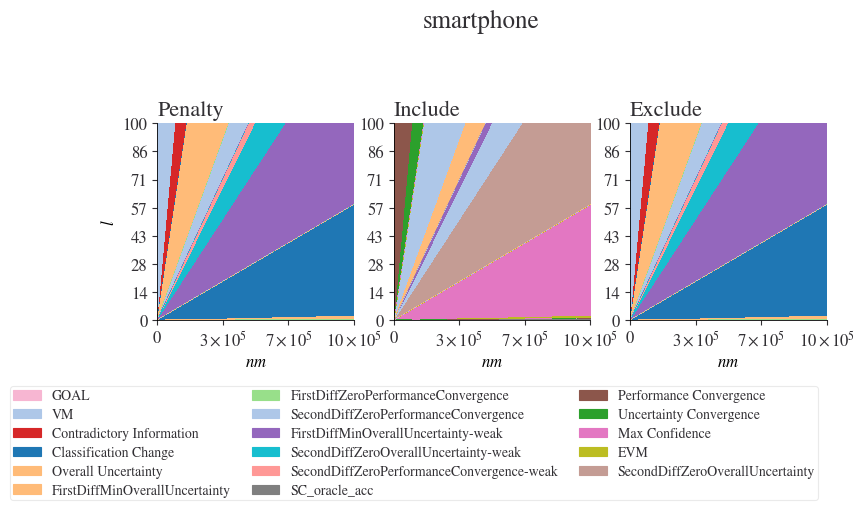

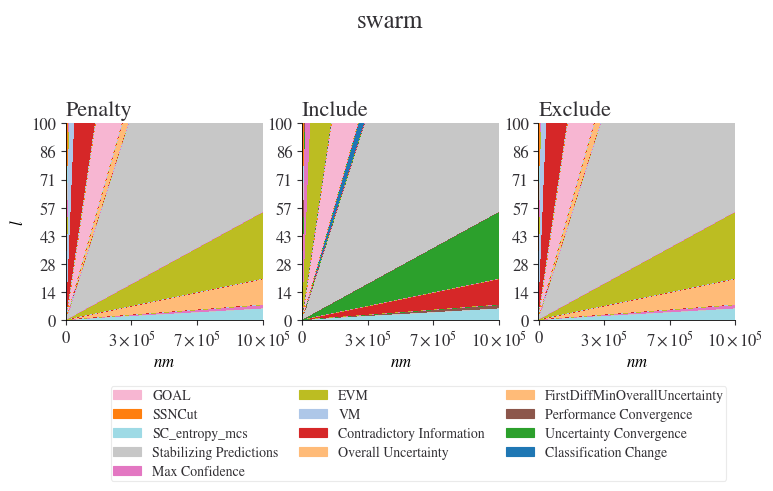

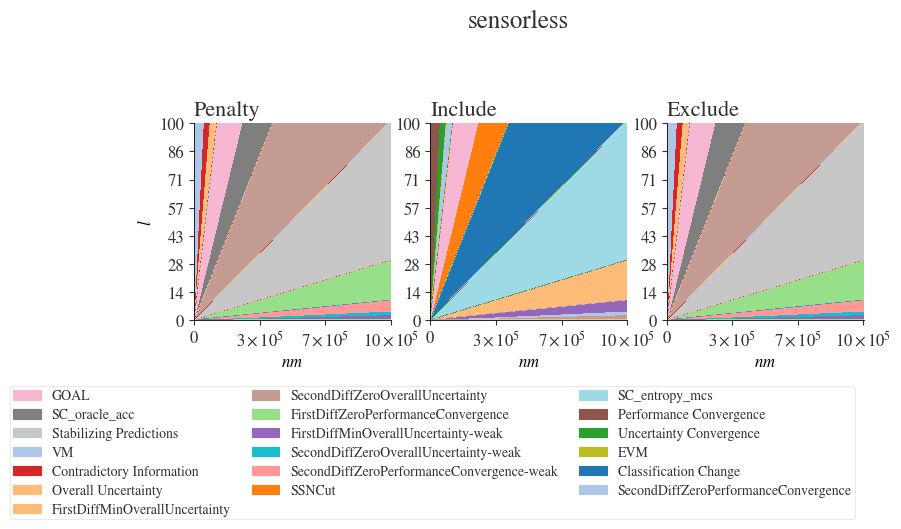

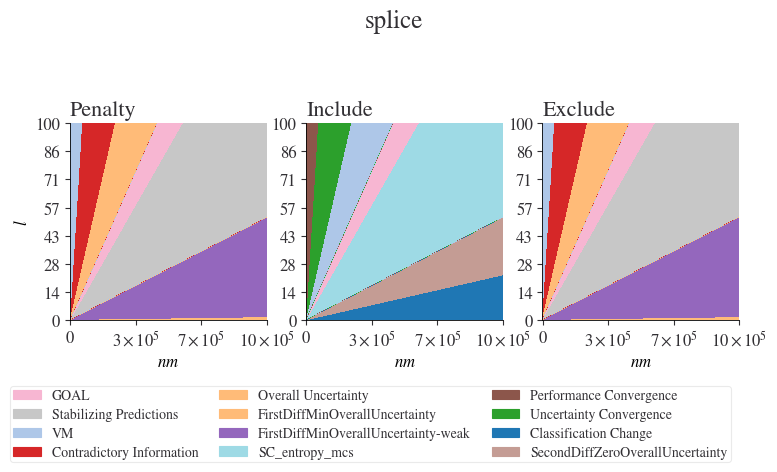

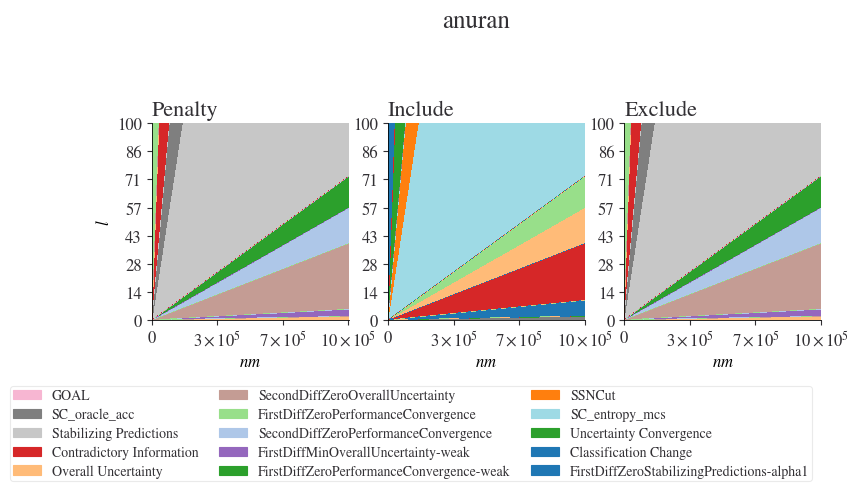

In [25]:
import libregionplot; reload(libregionplot); from libregionplot import regions, costs
with plt.style.context('plt_style.txt'):
    for dataset, r in results_filter.items():
        fig, axes = plt.subplots(1, 3, figsize=(7.2*1.2,4.45), dpi=100)
        patches = []
        for i, (ax, mode) in enumerate(zip(axes, ['penalty', 'include', 'exclude'])):
            regions({dataset: r}, colors=criteria_map, failed_to_stop=mode, title=mode.title(), ax=ax, patches=patches, left=i==0)
        plt.legend(handles=patches, bbox_to_anchor=(0.99, -0.3), ncol=3)
        plt.suptitle(dataset)

In [27]:
import math

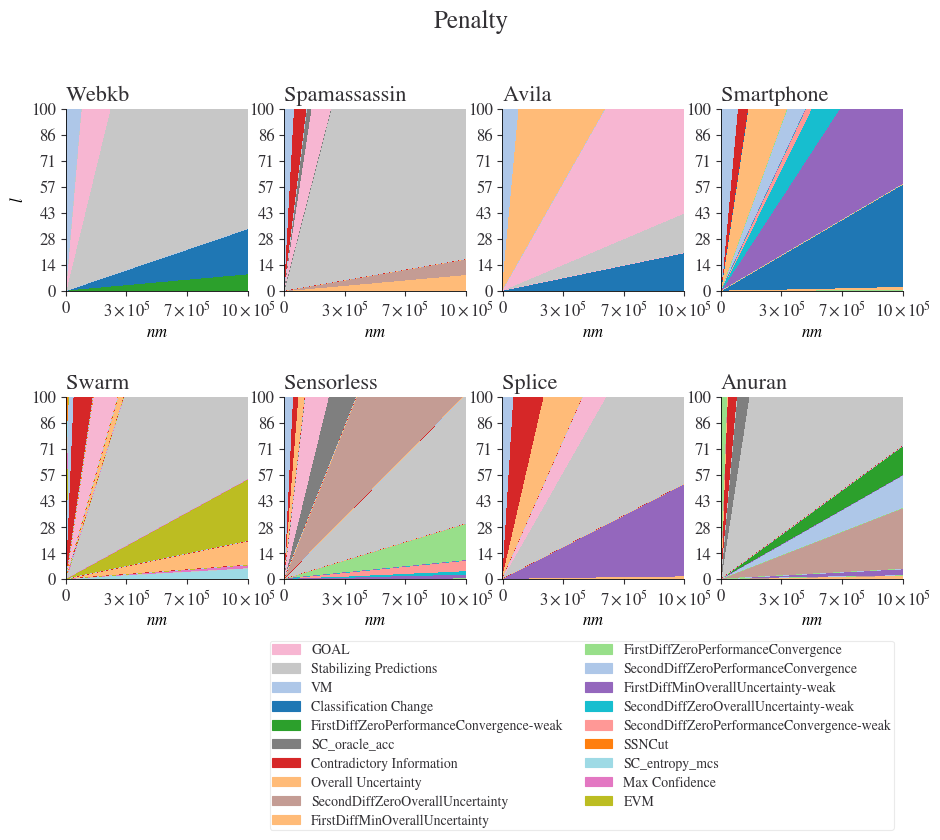

In [33]:
import libregionplot; reload(libregionplot); from libregionplot import regions, costs
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(math.ceil(len(results_filter)/4), 4, figsize=(7.2*1.5,7.), dpi=100)
    patches = []
    for i, ((dataset, r), ax) in enumerate(zip(results_filter.items(), axes.flatten())):
            regions({dataset: r}, colors=criteria_map, failed_to_stop="penalty", title=dataset.title(), ax=ax, patches=patches, left=i==0)
    plt.legend(handles=patches, bbox_to_anchor=(0.99, -0.3), ncol=2)
    plt.suptitle("Penalty")

### Without new derivatives

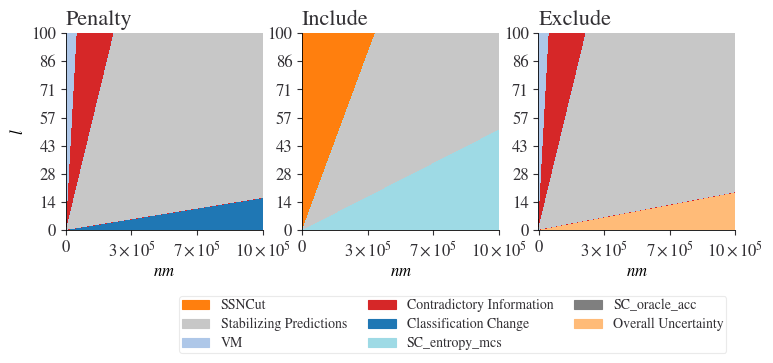

In [37]:
import libregionplot; reload(libregionplot); from libregionplot import regions, costs
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(1, 3, figsize=(7.2*1.2,4.45), dpi=100)
    patches = []
    for i, (ax, mode) in enumerate(zip(axes, ['penalty', 'include', 'exclude'])):
        regions(results_filter_min, colors=criteria_map, failed_to_stop=mode, title=mode.title(), ax=ax, patches=patches, left=i==0)
    plt.legend(handles=patches, bbox_to_anchor=(0.99, -0.3), ncol=3)

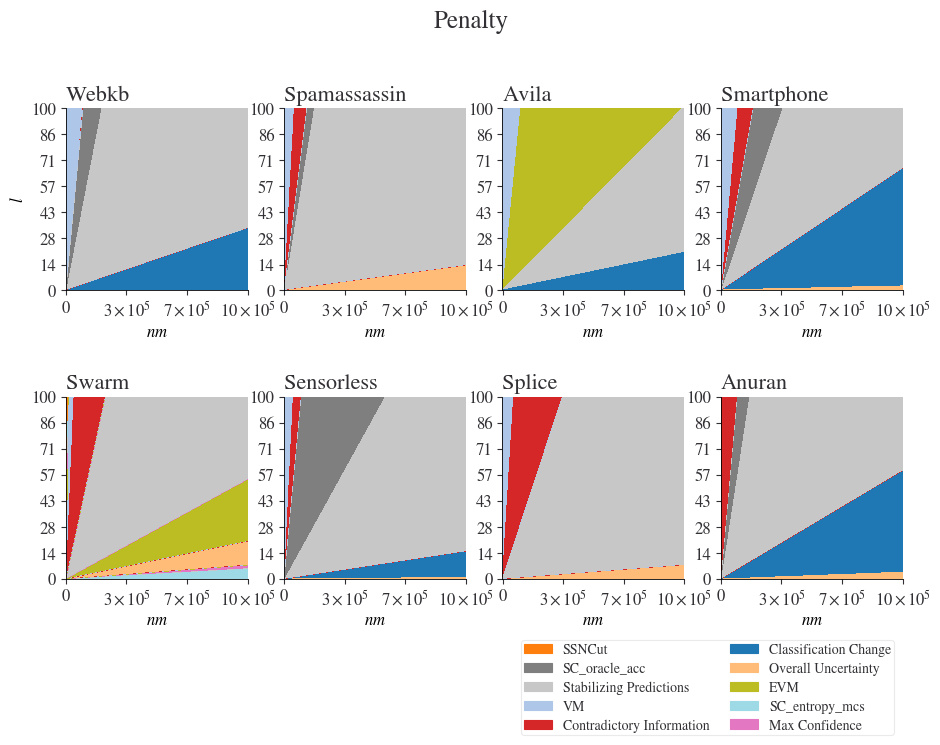

In [38]:
import libregionplot; reload(libregionplot); from libregionplot import regions, costs
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(math.ceil(len(results_filter_min)/4), 4, figsize=(7.2*1.5,7.), dpi=100)
    patches = []
    for i, ((dataset, r), ax) in enumerate(zip(results_filter_min.items(), axes.flatten())):
            regions({dataset: r}, colors=criteria_map, failed_to_stop="penalty", title=dataset.title(), ax=ax, patches=patches, left=i==0)
    plt.legend(handles=patches, bbox_to_anchor=(0.99, -0.3), ncol=2)
    plt.suptitle("Penalty")